In [1]:
%load_ext autoreload

import matplotlib.pyplot as plt

def plotit(x,y):
    fig, ax = plt.subplots()
    ax.plot(x,y, 'o')
    plt.show()

Controller configuration
-----------------------

Overall configuration is held in a class, Config. A Config object holds the list of linux containers, Corsa switches, simulated sites. The following is used to generate and save the configuration. It explains what the various data types are and being used. Refer to coord.py for more details on each of the objects.

In [207]:
%autoreload 2

from coord import Switch, DTN, Site, Config, get_config

# Corsa Switches - rtt to SCinet Denver.
wash_sw = Switch("wash-tb-of-1","192.168.120.41",None,vfc="br2",ofport=11,rtt=38.8)
cern_sw = Switch("cern-272-tb-of-1","192.168.120.36",None,"br2",10,rtt=89.5)
amst_sw = Switch("amst-tb-of-1","192.168.120.35",None,"br1",23,rtt=82.5)
aofa_sw = Switch("aofa-tb-of-1","192.168.120.33",None,"br2",2,rtt=5.3)
denv_sw = Switch("denv-tb-of-1","192.168.120.37",None,"br1",10,rtt=2)
atla_sw = Switch("atla-tb-of-1","192.168.120.34",None,"br1",9,rtt=39.5)
switches=[wash_sw,cern_sw,amst_sw,aofa_sw,denv_sw,atla_sw]

# Data Transfer Node
wash_dtn = DTN("wash-192","192.168.120.192",port="eth1")
cern_dtn = DTN("cern-194","192.168.120.194",port="eth1")
amst_dtn = DTN("amst-190","192.168.120.190",port="eth1")
aofa_dtn = DTN("aofa-191","192.168.120.191",port="eth1")
denv_dtn = DTN("denv-201","192.168.120.201",port="eth1")
atla_dtn = DTN("atla-200","192.168.120.200",port="eth1")
dtns = [wash_dtn,cern_dtn,amst_dtn,aofa_dtn,denv_dtn,atla_dtn]

# Simulated sites
wash = Site(name="wash", switch=wash_sw, dtn=wash_dtn)
amst = Site(name="amst", switch=amst_sw, dtn=amst_dtn)
cern = Site(name="cern", switch=cern_sw, dtn=cern_dtn)
denv = Site(name="denv", switch=denv_sw, dtn=denv_dtn)
aofa = Site(name="aofa", switch=aofa_sw, dtn=aofa_dtn)
atla = Site(name="atla", switch=atla_sw, dtn=atla_dtn)
#scinet = Site(name="scinet", switch=None, dtn=scinet_dtn)

sites = [wash,amst,cern,denv,aofa,atla]

config =Config(switches=switches,dtns=dtns,sites=sites)
config.save(config_file="demo.config")


Switches,dtn, etc are python objects. There is no access functions to their values. They can directly be accessed:

In [107]:
print wash_sw.ip, wash_sw.vfc, wash_sw.ofport, wash_sw.rtt

192.168.120.41 br2 11 38.8


In [108]:
print config.switches
print config.dtns
print config.sites

[wash-tb-of-1, cern-272-tb-of-1, amst-tb-of-1, aofa-tb-of-1, denv-tb-of-1, atla-tb-of-1]
[wash-192, cern-194, amst-190, aofa-191, denv-201, atla-200]
[wash, amst, cern, denv, aofa, atla]


Once the config is written into a file, it can be retrieved later:

In [113]:
new_config = get_config(config_file="demo.config")

In [115]:
new_config.dtns

[wash-192, cern-194, amst-190, aofa-191, denv-201, atla-200]

Traffic Generator
----------------

Current testing the default generator in coord.py (one file per source at the time). File size distribution is random and delivery delay (i.e. past min deadline) is exponential.

In [208]:
from coord import SingleFileGen

capacity = 500000 # 500 Mbps
epoch = 5 * 60 # 5 mins

buckets=[30*1024,15*1024,10*1024,5*1024,1*1025,512,128]
gen = SingleFileGen(dtns,capacity,epoch,buckets)
reqs = gen.generate_requests(iterations = 10, scale = 10)

The following shows the request for a given DTN

In [19]:
print wash_dtn.requests[0]

src= wash-192 dst: scinet-dtn size: 10240 deadline: 198.050128284 min_duration: 196.608


The first following graph shows the additional delay. The x are requests and y is the percentage of the theoritical minimum transfer time (i.e. going at full line rate without congestion + padding) that is added for the dealine. 

The second graph shows the file size distribution.

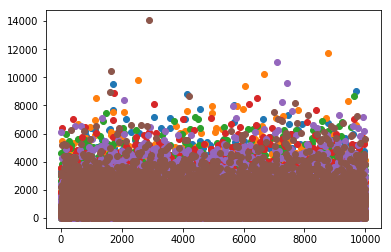

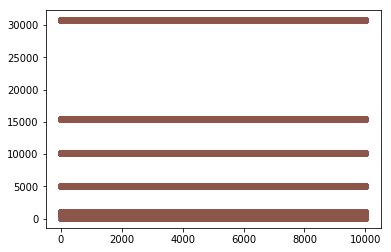

In [156]:
x=[]
y_delay=[]
y_size=[]
req_nb = 0
for req_epoch in reqs:
    x.append(req_nb)
    ys_delay = []
    ys_size = []
    for req in req_epoch:
        ys_delay.append(req.delay_ratio)
        ys_size.append(req.size)
    y_delay.append(ys_delay)
    y_size.append(ys_size)
    req_nb += 1
plotit(x,y_delay)
plotit(x,y_size)

Creating file of requests and storing them into a file.

In [209]:
gen.save("scenario.data",reqs)

A saved scenario can be loaded as follow:

In [109]:
reqs = SingleFileGen.load("scenario.data", dtns)

dtns[0].requests[0]

src= wash-192 dst: scinet-dtn size: 10240 deadline: 198.050128284 min_duration: 196.608

In [230]:

from coord import Coordinator

coord = Coordinator(name="caliber-slice",epoch_time=10,config_file="demo.config",scenario_file="scenario.data")

In [231]:
coord.start()

STARTING

call scheduler Mon Oct 30 08:47:37 2017
call scheduler Mon Oct 30 08:47:38 2017
call scheduler Mon Oct 30 08:47:39 2017
call scheduler Mon Oct 30 08:47:40 2017
call scheduler Mon Oct 30 08:47:41 2017
call scheduler Mon Oct 30 08:47:42 2017
call scheduler Mon Oct 30 08:47:43 2017
call scheduler Mon Oct 30 08:47:44 2017
call scheduler Mon Oct 30 08:47:45 2017
call scheduler Mon Oct 30 08:47:46 2017
call scheduler Mon Oct 30 08:47:47 2017
call scheduler Mon Oct 30 08:47:48 2017
call scheduler Mon Oct 30 08:47:49 2017
call scheduler Mon Oct 30 08:47:50 2017
call scheduler Mon Oct 30 08:47:51 2017
call scheduler Mon Oct 30 08:47:52 2017
call scheduler Mon Oct 30 08:47:53 2017
call scheduler Mon Oct 30 08:47:54 2017


In [232]:
coord.isRunning = False


Request simulation is stopped.
